In [22]:
import pandas as pd
import numpy as np
import geopandas as gpd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from datetime import datetime
from matplotlib import pyplot as plt
import scipy
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [31]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calander

## Data Downloading & Preprocessing

### 1.Uber Dataset Downloading

In [1]:
import requests
def downloadData():
    csv_url_head = 'https://s3.amazonaws.com/nyc-tlc/trip+data/fhvhv_tripdata_'  
    for year in ['2019','2020']:
        for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
            req = requests.get(csv_url_head+year+'-'+month+'.csv')
            url_content = req.content
            csv_file = open('hvfhv_tripdata_'+year+'-'+month+'.csv', 'wb')
            csv_file.write(url_content)
            csv_file.close()
#!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-01.csv > yellow_tripdata_2020-01.csv    
downloadData()

In [44]:
hvfhv = dd.read_csv('hvfhv_tripdata_20*.csv', 
                 dtype={'PULocationID': 'float64'},
                usecols=['hvfhs_license_num','dispatching_base_num','pickup_datetime','PULocationID'])

In [45]:
hvfhv['pickup_datetime'] = dd.to_datetime(hvfhv['pickup_datetime'])
hvfhv['PU_Date'] = hvfhv['pickup_datetime'].dt.normalize()
hvfhv['PU_Month'] = hvfhv['pickup_datetime'].dt.month
hvfhv['PU_Time'] = hvfhv['pickup_datetime'].dt.hour
hvfhv['PU_Weekday'] = hvfhv['pickup_datetime'].dt.day_name()

In [46]:
def time_slots(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,17):
        return 'Afternoon'
    elif x in range(17,22):
        return 'Evening'
    else:
        return 'Late Night'
def season_tag(x):
    if x in (1,2,12):
        return 'Winter'
    elif x in range(3,6):
        return 'Spring'
    elif x in range(6,9):
        return 'Summer'
    else:
        return 'Autumn'
    
hvfhv['time_desc'] = hvfhv['PU_Time'].apply(time_slots)
hvfhv['season'] = hvfhv['PU_Month'].apply(season_tag)

In [47]:
#keep taxi records from Uber company
%time Uber_data = hvfhv[hvfhv['hvfhs_license_num']=='HV0003'].compute()
#drop rows with unusual date
%time Uber_data = Uber_data[(Uber_data['pickup_datetime'].dt.year >2018) & (Uber_data['pickup_datetime'].dt.year <=2020)]

CPU times: user 13min 59s, sys: 4min 18s, total: 18min 18s
Wall time: 16min 52s
CPU times: user 1min 36s, sys: 4min 45s, total: 6min 21s
Wall time: 9min 21s


In [48]:
#cal = calander()
#holidays = cal.holidays(start='2019-01-01', end='2020-12-31')
#Uber_data['PU_holiday'] = Uber_data['PU_Date'].isin(holidays)
Uber_data['PU_DOW'] = Uber_data['PU_Date'].dt.dayofweek

#Uber_data.loc[Uber_data['PU_week'] >= 5, 'day_type'] = "weekend"
#Uber_data.loc[Uber_data['PU_week'] < 5, 'day_type'] = "workday"
#Uber_data.loc[Uber_data['holiday'] == True, 'day_type'] = "holiday"
#Uber_data = Uber_data.drop(['holiday', 'week'], axis=1)
Uber_data['PU_year'] = Uber_data['pickup_datetime'].dt.year

In [49]:
#output uber data to csv and save for next time use
Uber_data.to_csv("uber_data_19-20.csv")

In [3]:
Uber_data = dd.read_csv('uber_data_19-20.csv')

In [4]:
Uber_data.head()

,Unnamed: 0,hvfhs_license_num,dispatching_base_num,pickup_datetime,PULocationID,PU_Date,PU_Month,PU_Time,PU_Weekday,time_desc,season,PU_DOW,PU_year
0,0,HV0003,B02867,2019-02-01 00:05:18,245.0,2019-02-01 00:00:00,2,0,Friday,Late Night,Winter,4,2019
1,1,HV0003,B02879,2019-02-01 00:41:29,216.0,2019-02-01 00:00:00,2,0,Friday,Late Night,Winter,4,2019
2,8,HV0003,B02867,2019-02-01 00:10:48,226.0,2019-02-01 00:00:00,2,0,Friday,Late Night,Winter,4,2019
3,9,HV0003,B02867,2019-02-01 00:32:32,7.0,2019-02-01 00:00:00,2,0,Friday,Late Night,Winter,4,2019
4,10,HV0003,B02867,2019-02-01 00:59:54,129.0,2019-02-01 00:00:00,2,0,Friday,Late Night,Winter,4,2019


### 1.1 average ridership between different time slot and day of week on different season(barplot)

In [92]:
%time Uber_aggby_count = Uber_data.groupby(['PU_year','season','PU_Weekday','PU_Date','time_desc']).count()[['PULocationID']].compute()
Uber_aggby_count.reset_index(inplace=True)

CPU times: user 7min 32s, sys: 1min 42s, total: 9min 15s
Wall time: 4min 29s


In [93]:
%time Uber_aggby_avg = Uber_aggby_count.groupby(['PU_year','season','PU_Weekday','time_desc']).mean()[['PULocationID']]
Uber_aggby_avg.reset_index(inplace=True)

CPU times: user 4.6 ms, sys: 1.97 ms, total: 6.57 ms
Wall time: 5.16 ms


In [94]:
Uber_aggby_avg.head()

,PU_year,season,PU_Weekday,time_desc,PULocationID
0,2019,Autumn,Friday,Afternoon,114645.076923
1,2019,Autumn,Friday,Evening,162410.230769
2,2019,Autumn,Friday,Late Night,126085.076923
3,2019,Autumn,Friday,Morning,125991.846154
4,2019,Autumn,Monday,Afternoon,96364.307692


In [95]:
Uber_aggby_avg.rename(columns={'PULocationID':'avg_trips'},inplace=True)
Uber_aggby_avg['avg_trips']=Uber_aggby_avg['avg_trips'].astype('int64')

In [96]:
agg_2019_winter= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2019)&(Uber_aggby_avg['season']=='Winter')]
agg_2019_summer= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2019)&(Uber_aggby_avg['season']=='Summer')]
agg_2020_winter= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2020)&(Uber_aggby_avg['season']=='Winter')]
agg_2020_summer= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2020)&(Uber_aggby_avg['season']=='Summer')]

In [97]:
agg_2019_winter.head()

,PU_year,season,PU_Weekday,time_desc,avg_trips
84,2019,Winter,Friday,Afternoon,119091
85,2019,Winter,Friday,Evening,174791
86,2019,Winter,Friday,Late Night,126902
87,2019,Winter,Friday,Morning,131031
88,2019,Winter,Monday,Afternoon,106170


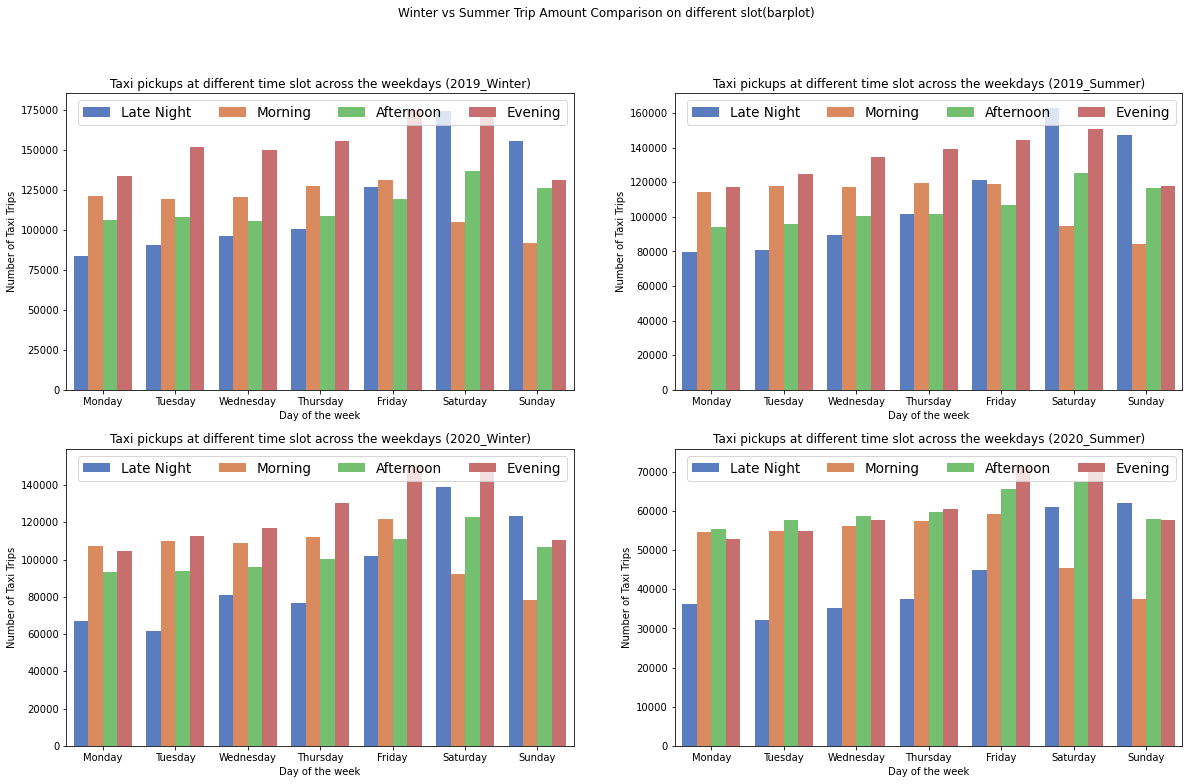

In [98]:
#Winter vs Summer Trip Amount Comparison on different slot(barplot)
wkOrder = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
timeSlotOrder = ['Late Night', 'Morning', 'Afternoon', 'Evening']
#fig, ax = plt.subplots(figsize=(7,4))
fig, ax_arr = plt.subplots(2,2, figsize=(20,12))
sns.barplot(x=agg_2019_winter.PU_Weekday, y=agg_2019_winter.avg_trips, hue=agg_2019_winter.time_desc,\
            order =wkOrder ,hue_order = timeSlotOrder,ax=ax_arr[0][0], palette = 'muted')
ax_arr[0][0].set_ylabel('Number of Taxi Trips')
ax_arr[0][0].set_xlabel('Day of the week')
ax_arr[0][0].set_title('Taxi pickups at different time slot across the weekdays (2019_Winter)')
ax_arr[0][0].legend(loc=1, ncol=4, prop={'size': 13.5})

sns.barplot(x=agg_2019_summer.PU_Weekday, y=agg_2019_summer.avg_trips, hue=agg_2019_summer.time_desc,\
            order =wkOrder ,hue_order = timeSlotOrder,ax=ax_arr[0][1], palette = 'muted')
ax_arr[0][1].set_ylabel('Number of Taxi Trips')
ax_arr[0][1].set_xlabel('Day of the week')
ax_arr[0][1].set_title('Taxi pickups at different time slot across the weekdays (2019_Summer)')
ax_arr[0][1].legend(loc=1, ncol=4, prop={'size': 13.5})

sns.barplot(x=agg_2020_winter.PU_Weekday, y=agg_2020_winter.avg_trips, hue=agg_2020_winter.time_desc,\
            order =wkOrder ,hue_order = timeSlotOrder,ax=ax_arr[1][0], palette = 'muted')
ax_arr[1][0].set_ylabel('Number of Taxi Trips')
ax_arr[1][0].set_xlabel('Day of the week')
ax_arr[1][0].set_title('Taxi pickups at different time slot across the weekdays (2020_Winter)')
ax_arr[1][0].legend(loc=1, ncol=4, prop={'size': 13.5})

sns.barplot(x=agg_2020_summer.PU_Weekday, y=agg_2020_summer.avg_trips, hue=agg_2020_summer.time_desc,\
            order =wkOrder ,hue_order = timeSlotOrder,ax=ax_arr[1][1], palette = 'muted')
ax_arr[1][1].set_ylabel('Number of Taxi Trips')
ax_arr[1][1].set_xlabel('Day of the week')
ax_arr[1][1].set_title('Taxi pickups at different time slot across the weekdays (2020_Summer)')
ax_arr[1][1].legend(loc=1, ncol=4, prop={'size': 13.5})
plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('Winter vs Summer Trip Amount Comparison on different slot(barplot)')
plt.show()

### 1.2 Average Ridership between different time and DOW on different season(heatmap)

In [99]:
%time Uber_aggby_count = Uber_data.groupby(['PU_year','season','PU_Weekday','PU_Date','PU_Time']).count()[['PULocationID']].compute()
Uber_aggby_count.reset_index(inplace=True)

CPU times: user 7min 52s, sys: 1min 57s, total: 9min 49s
Wall time: 4min 53s


In [100]:
%time Uber_aggby_avg = Uber_aggby_count.groupby(['PU_year','season','PU_Weekday','PU_Time']).mean()[['PULocationID']]
Uber_aggby_avg.reset_index(inplace=True)

CPU times: user 8.44 ms, sys: 2.27 ms, total: 10.7 ms
Wall time: 9.38 ms


In [102]:
Uber_aggby_avg.rename(columns={'PULocationID':'avg_trips'},inplace=True)
Uber_aggby_avg['avg_trips']=Uber_aggby_avg['avg_trips'].astype('int64')

In [103]:
agg_2019_winter= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2019)&(Uber_aggby_avg['season']=='Winter')]
agg_2019_summer= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2019)&(Uber_aggby_avg['season']=='Summer')]
agg_2020_winter= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2020)&(Uber_aggby_avg['season']=='Winter')]
agg_2020_summer= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2020)&(Uber_aggby_avg['season']=='Summer')]

In [130]:
pv_table_2019_winter = pd.pivot_table(agg_2019_winter, values='avg_trips',index=['PU_Time'],columns=['PU_Weekday'], aggfunc=np.sum, fill_value=0)
pv_table_2019_summer = pd.pivot_table(agg_2019_summer, values='avg_trips',index=['PU_Time'],columns=['PU_Weekday'], aggfunc=np.sum, fill_value=0)
pv_table_2020_winter = pd.pivot_table(agg_2020_winter, values='avg_trips',index=['PU_Time'],columns=['PU_Weekday'], aggfunc=np.sum, fill_value=0)
pv_table_2020_summer = pd.pivot_table(agg_2020_summer, values='avg_trips',index=['PU_Time'],columns=['PU_Weekday'], aggfunc=np.sum, fill_value=0)

In [131]:
pv_table_2019_winter = pv_table_2019_winter[[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].sort_values(by='PU_Time',ascending=False)
pv_table_2019_summer = pv_table_2019_summer[[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].sort_values(by='PU_Time',ascending=False)
pv_table_2020_winter = pv_table_2020_winter[[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].sort_values(by='PU_Time',ascending=False)
pv_table_2020_summer = pv_table_2020_summer[[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].sort_values(by='PU_Time',ascending=False)

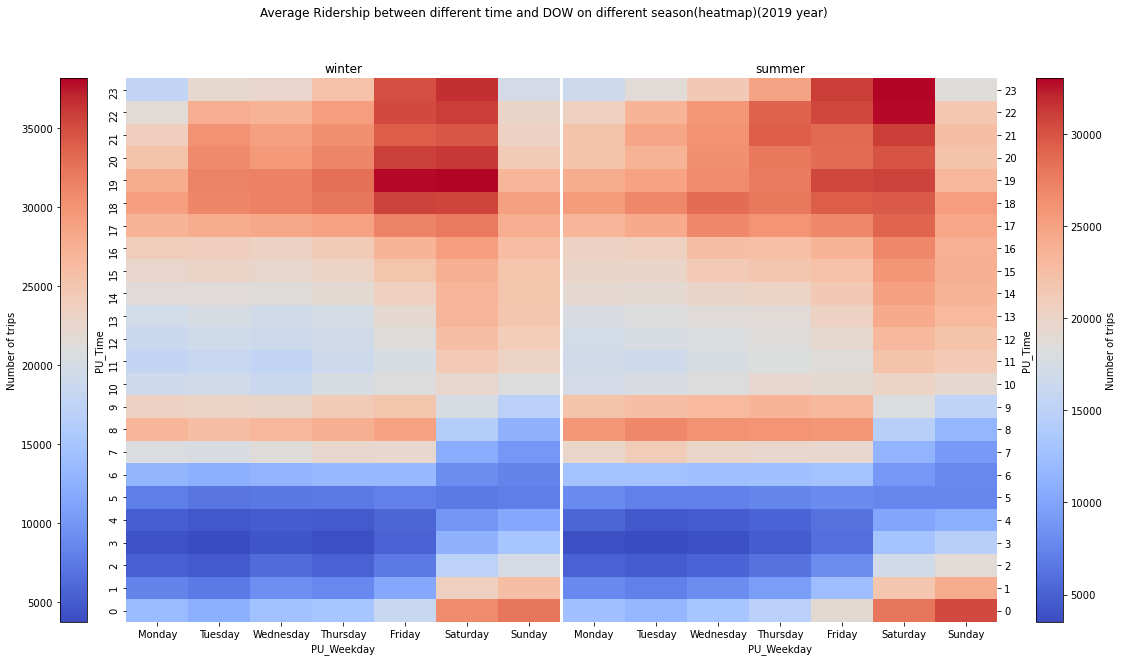

In [132]:
fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(20, 10))
fig.subplots_adjust(wspace=0.005)

day_hour_winter = sns.heatmap(pv_table_2019_winter, ax=ax, cmap="coolwarm", cbar=False)
fig.colorbar(ax.collections[0], label='Number of trips', ax=ax,location="left", use_gridspec=False, pad=0.07)

day_hour_summer = sns.heatmap(pv_table_2019_summer, ax=ax2, cmap="coolwarm", cbar=False)
fig.colorbar(ax2.collections[0], label='Number of trips', ax=ax2,location="right", use_gridspec=False, pad=0.07)
ax.set_title('winter')
ax2.set_title('summer')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
fig.suptitle('Average Ridership between different time and DOW on different season(heatmap)(2019 year)')
plt.show()

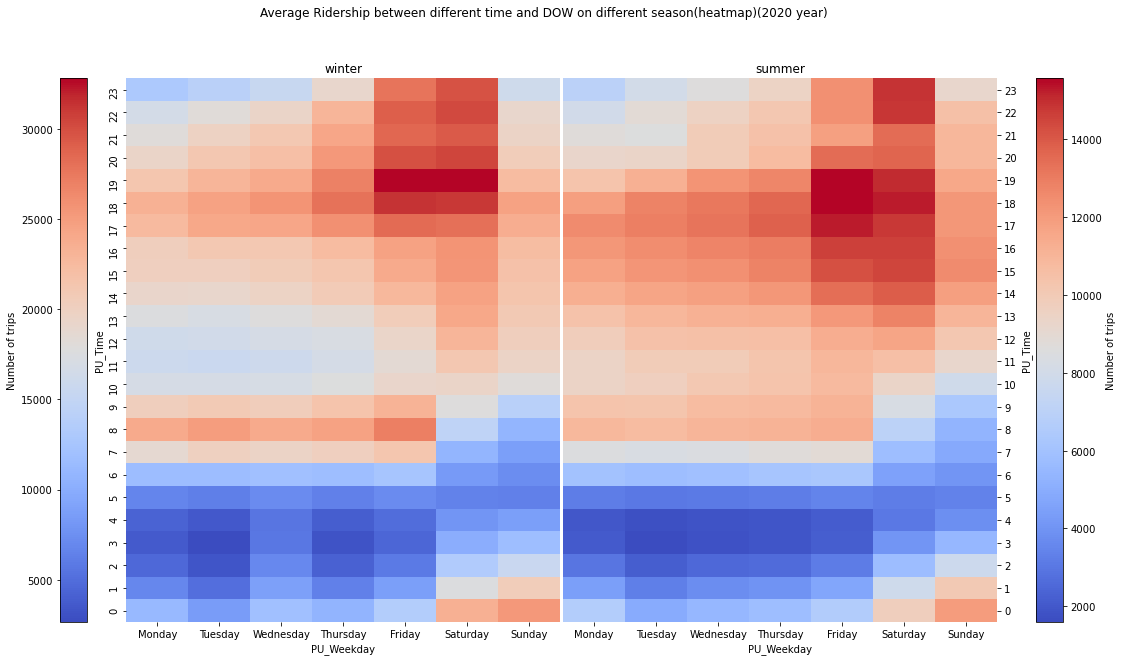

In [133]:
fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(20, 10))
fig.subplots_adjust(wspace=0.005)

day_hour_winter = sns.heatmap(pv_table_2020_winter, ax=ax, cmap="coolwarm", cbar=False)
fig.colorbar(ax.collections[0], label='Number of trips', ax=ax,location="left", use_gridspec=False, pad=0.07)

day_hour_summer = sns.heatmap(pv_table_2020_summer, ax=ax2, cmap="coolwarm", cbar=False)
fig.colorbar(ax2.collections[0], label='Number of trips', ax=ax2,location="right", use_gridspec=False, pad=0.07)
ax.set_title('winter')
ax2.set_title('summer')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
fig.suptitle('Average Ridership between different time and DOW on different season(heatmap)(2020 year)')
plt.show()

### 2.NYC Weather Data Processing

In [9]:
USA_weather = pd.read_csv('nyc_weather_data.csv',usecols=['STATION','NAME','DATE','AWND','PRCP','SNOW','SNWD','TMAX','TMIN'])
USA_weather.head()

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN
0,USC00280907,"BOONTON 1 SE, NJ US",2018-01-01,0.00,0.0,0.0,13.0,4.0
1,USC00280907,"BOONTON 1 SE, NJ US",2018-01-02,0.00,0.0,0.0,17.0,3.0
2,USC00280907,"BOONTON 1 SE, NJ US",2018-01-03,0.00,0.0,0.0,24.0,7.0
3,USC00280907,"BOONTON 1 SE, NJ US",2018-01-04,0.00,0.0,0.0,27.0,5.0
4,USC00280907,"BOONTON 1 SE, NJ US",2018-01-05,0.56,5.0,5.0,24.0,7.0


In [11]:
# Chose the weather information for Central Park to represent the weather conditions in New York City
#Time range(year):2019~2020
USA_weather['DATE'] = pd.to_datetime(USA_weather['DATE'])
NYC_weather = USA_weather.loc[USA_weather['STATION']=='USW00094728']
NYC_weather = NYC_weather.loc[(NYC_weather['DATE']>='2019-01-01') & (NYC_weather['DATE']<='2020-12-31')]
#NYC_weather['Date'] =NYC_weather['DATE'].dt.date

In [13]:
NYC_weather.shape

(731, 8)

In [ ]:
NYC_weather['TAVG'] = (NYC_weather['TMAX']+NYC_weather['TMIN'])/2

### 3. merge ridership data with weather

In [ ]:
Uber_aggby_date = Uber_data.groupby(['PU_year','season','PU_Date']).count()[['PULocationID']]

In [ ]:
taxi_weather_data = pd.DataFrame(pd.merge(Uber_aggby_date, weather, left_on='PU_Date', right_on='DATE')).drop('DATE', axis=1)

In [ ]:
#Uber taxi ridership distribution by precipitation(inches)


In [ ]:
#Uber taxi ridership distribution by temperature(F)

In [ ]:
#Uber taxi ridership distribution by snowfall(inches)